---
title: "least squares"
execute:
  # echo: false
  freeze: auto  # re-render only when source changes
format:
  html:
    code-fold: true
    code-summary: "Show the code"
---

## ordinary least squares (OLS) regression

Let's go over a few things that appear in this notebook, [statsmodels, Ordinary Least Squares](https://www.statsmodels.org/dev/examples/notebooks/generated/ols.html)

In [1]:
#| code-summary: "import libraries"
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
sns.set_theme(style="ticks", font_scale=1.5)
np.random.seed(9876789)

## polynomial regression

Let's start with a simple polynomial regression example. We will start by generating synthetic data for a quadratic equation plus some noise.

In [ ]:
#| code-summary: "create data"
#| code-fold: false
# number of points
nsample = 100
# create independent variable x
x = np.linspace(0, 10, 100)
# create design matrix with linear and quadratic terms
X = np.column_stack((x, x ** 2))
# create coefficients array
beta = np.array([5, -2, 0.5])
# create random error term
e = np.random.normal(size=nsample)

$x$ and $e$ can be understood as column vectors of length $n$, while $X$ and $\beta$ are:

$$
X = 
\begin{pmatrix}
x_0 & x_0^2 \\
| & | \\
x_i & x_i^2 \\
| & | \\
x_n & x_n^2 \\
\end{pmatrix}, \qquad
\beta = 
\begin{pmatrix}
\beta_0 \\
\beta_1 \\
\beta_2
\end{pmatrix}.
$$

Oops, there is no intercept column $\vec{1}$ in the design matrix $X$. Let's add it:

In [3]:
#| code-summary: "add intercept to design matrix"
#| code-fold: false
X = sm.add_constant(X)
print(X[:5, :])  # print first 5 rows of design matrix

[[1.         0.         0.        ]
 [1.         0.1010101  0.01020304]
 [1.         0.2020202  0.04081216]
 [1.         0.3030303  0.09182736]
 [1.         0.4040404  0.16324865]]


This `add_constant` function is smart, it has as default a `prepend=True` argument, meaning that the intercept is added as the first column, and a `has_constant='skip'` argument, meaning that it will not add a constant if one is already present in the matrix.

The matrix $X$ is now a **design matrix** for a polynomial regression of degree 2.
$$
X = 
\begin{pmatrix}
1 & x_0 & x_0^2 \\
| & | & | \\
1 & x_i & x_i^2 \\
| & | & | \\
1 & x_n & x_n^2 \\
\end{pmatrix}
$$

We now put everything together in the following equation:

$$
y = X \beta + e
$$

This creates the dependend variable $y$ as a linear combination of the independent variables in $X$ and the coefficients in $\beta$, plus an error term $e$.

In [4]:
#| code-summary: "generate dependent variable"
#| code-fold: false
y = np.dot(X, beta) + e

Let's visualize this:

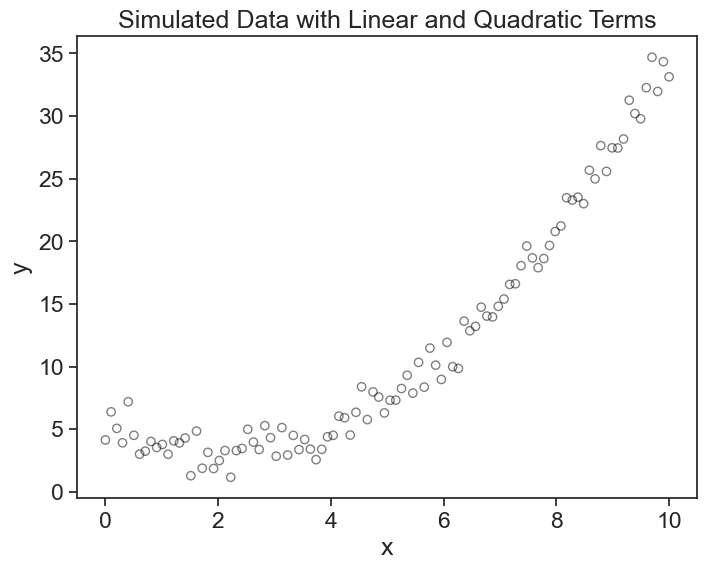

In [5]:
#| code-summary: "plot"
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(x, y, label='data', facecolors='none', edgecolors='black', alpha=0.5)
ax.set(xlabel='x',
       ylabel='y',
       title='Simulated Data with Linear and Quadratic Terms'
       );

## solving the "hard way"

I'm going to do something that nobody does. I will use the formula we derived in the previous chapter to find the coefficients $\beta$ of the polynomial regression.

$$
\beta = (X^TX)^{-1}X^Ty.
$$

Translating this into code, and keeping in mind that matrix multiplication in Python is done with the `@` operator, we get:

In [6]:
#| code-summary: "apply equation to find coefficients"
#| code-fold: false
beta_opt = np.linalg.inv(X.T@X)@X.T@y
print(f"beta = {beta_opt}")

beta = [ 5.34233516 -2.14024948  0.51025357]


That's it. We did it (again).

Let's take a look at the matrix $X^TX$. Because $X$ is a tall and skinny matrix of shape $(n, 3)$, the matrix $X^T$ is a wide and short matrix of shape $(3, n)$. This is because we have many more data points $n$ than the number of predictors ($\vec{1},x,x^2$), which is of course equal to the number of coefficients $(\beta_0,\beta_1,\beta_2)$.

In [7]:
#| code-summary: "print X^T * X"
#| code-fold: false
print(X.T@X)

[[1.00000000e+02 5.00000000e+02 3.35016835e+03]
 [5.00000000e+02 3.35016835e+03 2.52525253e+04]
 [3.35016835e+03 2.52525253e+04 2.03033670e+05]]


When we multiply the matrices $X^T_{3\times n}$ and $X_{n\times 3}$, we get a square matrix of shape $(3, 3)$, because the inner dimensions match (the number of columns in $X^T$ is equal to the number of rows in $X$).
The product $X^TX$ is a square matrix of shape $(3, 3)$, which is quite easy to invert. If it were the other way around ($X\,X^T$), we would have a matrix of shape $(n, n)$, which is much harder to invert, especially if $n$ is large. Lucky us.

Now let's see if the parameters we found are any good.

In [8]:
#| code-summary: "compare beta parameters"
#| code-fold: false
print("beta parameters used to generate data:")
print(beta)
print("beta parameters estimated from data:")
print(beta_opt)

beta parameters used to generate data:
[ 5.  -2.   0.5]
beta parameters estimated from data:
[ 5.34233516 -2.14024948  0.51025357]


Pretty good, right? Now let's see the best fit polynomial on the graph.

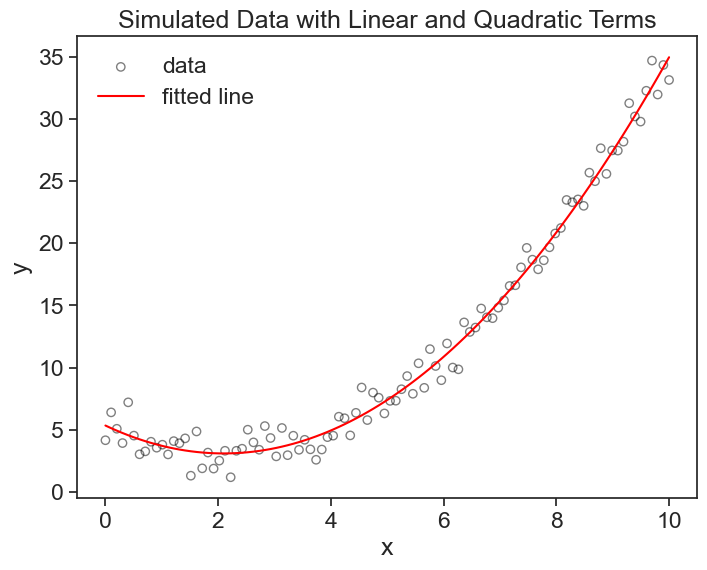

In [9]:
#| code-summary: "plot"
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(x, y, label='data', facecolors='none', edgecolors='black', alpha=0.5)
ax.plot(x, np.dot(X, beta_opt), color='red', label='fitted line')
ax.legend(frameon=False)
ax.set(xlabel='x',
       ylabel='y',
       title='Simulated Data with Linear and Quadratic Terms'
       );

Why did I call it the "hard way"? Because these operations are so common that of course there are libraries that do this for us. We don't need to remember the equation, we can just use, for example, `statsmodels` library's `OLS` function, which does exactly this. Let's see how it works.

In [10]:
#| code-summary: "print X^T * X"
#| code-fold: false
model = sm.OLS(y, X)
results = model.fit()

Now we can compare the results of our manual calculation with the results from `statsmodels`. We should get the same coefficients, and we do.

In [11]:
#| code-summary: "compare beta parameters"
#| code-fold: false
print("beta parameters used to generate data:")
print(beta)
print("beta parameters from our calculation:")
print(beta_opt)
print("beta parameters from statsmodels:")
print(results.params)

beta parameters used to generate data:
[ 5.  -2.   0.5]
beta parameters from our calculation:
[ 5.34233516 -2.14024948  0.51025357]
beta parameters from statsmodels:
[ 5.34233516 -2.14024948  0.51025357]


## statmodels.OLS and the summary

Statmodels provides us a lot more information than just the coefficients. Let's take a look at the summary of the OLS regression.

In [12]:
#| code-summary: "print summary"
#| code-fold: false
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.988
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                     3965.
Date:                Mon, 23 Jun 2025   Prob (F-statistic):           9.77e-94
Time:                        12:50:31   Log-Likelihood:                -146.51
No. Observations:                 100   AIC:                             299.0
Df Residuals:                      97   BIC:                             306.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.3423      0.313     17.083      0.0

I won't go into the details of the summary, but I encourage you to take a look at it and see if you can make sense of it.

## any function will do

The formula we derived the the previous chapter works for predictors (independent variables) of any kind, not only polynomials. The formula will work as long as the parameters $\beta$ are linear in the predictors. For exammple, we could have a nonlinear function like this:

$$
y = \beta_0 + \beta_1 e^x + \beta_2 \sin(x^2)
$$

because each beta multiplies a predictor. On the other hand, the following function would not work, because the parameters are not linear in the predictors:

$$
y = \beta_0 + e^{\beta_1 x} + \sin(\beta_2 x^2)
$$

Let's this this in action, I'll use the same example provided by `statsmodels` documentation, which is a nonlinear function of the form:

$$
y = \beta_0 x + \beta_1 \sin(x) + \beta_2(x - 5)^2 + \beta_3
$$

In [15]:
#| code-summary: "non polynomial example"
#| code-fold: false
nsample = 50
sig = 0.5
x = np.linspace(0, 20, nsample)
X = np.column_stack((
    x,
    np.sin(x),
    (x - 5) ** 2,
    np.ones(nsample)
    ))
beta = [0.5, 0.5, -0.02, 5.0]
y_true = np.dot(X, beta)
y = y_true + sig * np.random.normal(size=nsample)

[Text(0.5, 0, 'x'), Text(0, 0.5, 'y')]

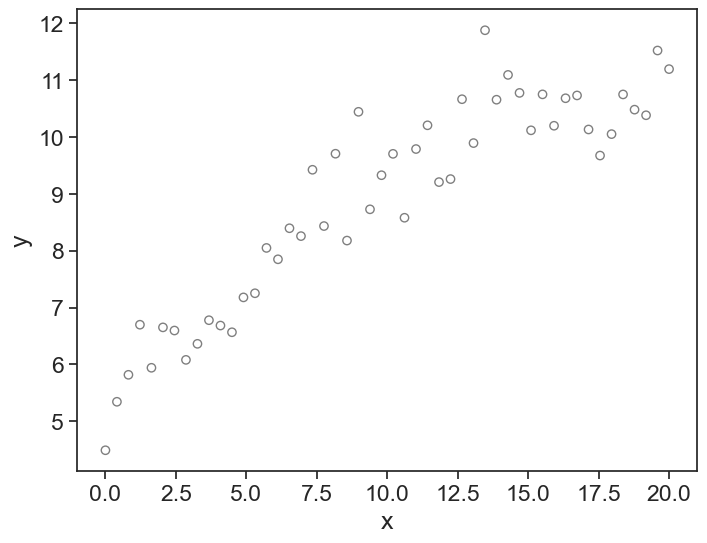

In [16]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(x, y, label='data', facecolors='none', edgecolors='black', alpha=0.5)
ax.set(xlabel='x',
       ylabel='y',
       )

In [17]:
result = sm.OLS(y, X).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.933
Model:                            OLS   Adj. R-squared:                  0.928
Method:                 Least Squares   F-statistic:                     211.8
Date:                Mon, 23 Jun 2025   Prob (F-statistic):           6.30e-27
Time:                        12:51:08   Log-Likelihood:                -34.438
No. Observations:                  50   AIC:                             76.88
Df Residuals:                      46   BIC:                             84.52
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.4687      0.026     17.751      0.0

Note something interesting: in our design matrix $X$, we encoded the intercept column as the last column, there is no reason why it should be the first column (although first column is a common choice). The function 'statsmodels.OLS' sees this, and when we print the summary, it will show the intercept as the last coefficient. Nice!

Let's see a graph of the data and the fitted model.

[Text(0.5, 0, 'x'), Text(0, 0.5, 'y')]

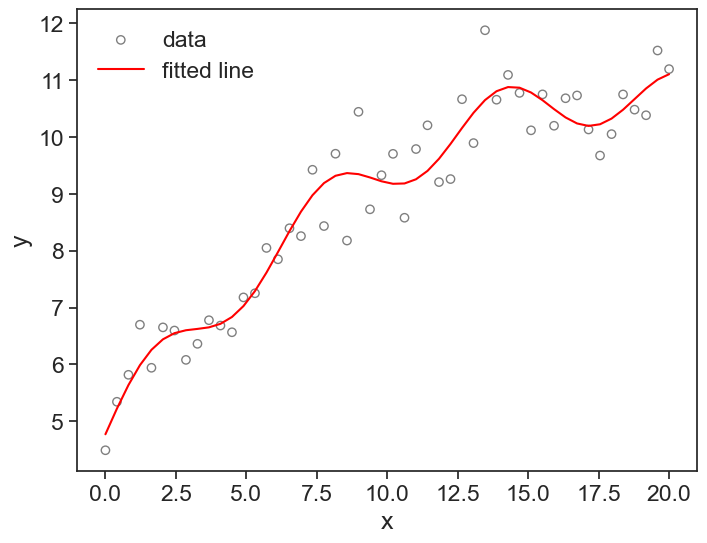

In [18]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(x, y, label='data', facecolors='none', edgecolors='black', alpha=0.5)
ax.plot(x, np.dot(X, result.params), color='red', label='fitted line')
ax.legend(frameon=False)
ax.set(xlabel='x',
       ylabel='y',
       )